In [ ]:
# Check GPU type
!nvidia-smi

Mon Dec  2 09:37:13 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Install ultralytics
!pip -q install  ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 896.9/896.9 kB 20.3 MB/s eta 0:00:00


In [ ]:
# Import libraries
import pandas as pd
import os
from pathlib import Path
import shutil
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import cv2
import yaml
import matplotlib.pyplot as plt
from ultralytics import YOLO
import multiprocessing

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
# Path to where your data is stored
DATA_DIR = Path('/content/drive/MyDrive/Lacuna')

# Preview data files available
os.listdir(DATA_DIR)

['images.zip', 'Test.csv', 'Train.csv', 'datasets', 'SampleSubmission.csv']

In [ ]:
# Set up directoris for training a yolo model

# Images directories
DATASET_DIR = Path('datasets/dataset')
IMAGES_DIR = DATASET_DIR / 'images'
TRAIN_IMAGES_DIR = IMAGES_DIR / 'train'
VAL_IMAGES_DIR = IMAGES_DIR / 'val'
TEST_IMAGES_DIR = IMAGES_DIR / 'test'

# Labels directories
LABELS_DIR = DATASET_DIR / 'labels'
TRAIN_LABELS_DIR = LABELS_DIR / 'train'
VAL_LABELS_DIR = LABELS_DIR / 'val'
TEST_LABELS_DIR = LABELS_DIR / 'test'

In [ ]:
# Unzip images to 'images' dir
shutil.unpack_archive(DATA_DIR / 'images.zip', 'images')
#!unzip content/drive/MyDrive/Lacuna/images.zip -d content/drive/MyDrive/Lacuna/images

In [ ]:
# Load train and test files
train = pd.read_csv(DATA_DIR / 'Train.csv')
test = pd.read_csv(DATA_DIR / 'Test.csv')
ss = pd.read_csv(DATA_DIR / 'SampleSubmission.csv')

# Add an image_path column
train['image_path'] = [Path('images/' + x) for x in train.Image_ID]
test['image_path'] = [Path('images/' + x) for x in test.Image_ID]

# Map str classes to ints (label encoding targets)
train['class_id'] = train['class'].map({'Trophozoite': 0, 'WBC': 1, 'NEG': 2})

# Preview the head of the train set
train.head()

,Image_ID,class,confidence,ymin,xmin,ymax,xmax,image_path,class_id
0,id_u3q6jdck4j.jpg,Trophozoite,1.0,712,1241,737,1270,images/id_u3q6jdck4j.jpg,0
1,id_a6cl90trri.jpg,Trophozoite,1.0,558,1566,600,1604,images/id_a6cl90trri.jpg,0
2,id_qvc2le9sm8.jpg,Trophozoite,1.0,1317,2788,1448,2914,images/id_qvc2le9sm8.jpg,0
3,id_w8xnbd5rvm.jpg,Trophozoite,1.0,925,1744,1041,1823,images/id_w8xnbd5rvm.jpg,0
4,id_6dop09rk02.jpg,NEG,1.0,0,0,0,0,images/id_6dop09rk02.jpg,2


In [ ]:
# Filter out NEG class (Negative images - this images have no Trophozoite nor WBC in them)
# Yolo reccomends that when creating labels for negative images, you leave them empty
# https://github.com/ultralytics/yolov5/issues/3218
# As this is a starter nb, we will ignore the negative images
train = train[~(train['class'] == 'NEG')].reset_index(drop = True)

In [ ]:
# Split data into training and validation
train_unique_imgs_df = train.drop_duplicates(subset = ['Image_ID'], ignore_index = True)
X_train, X_val = train_test_split(train_unique_imgs_df, test_size = 0.25, stratify=train_unique_imgs_df['class'], random_state=42)

X_train = train[train.Image_ID.isin(X_train.Image_ID)]
X_val = train[train.Image_ID.isin(X_val.Image_ID)]

# Check shapes of training and validation data
X_train.shape, X_val.shape

((17354, 9), (5488, 9))

In [ ]:
# Preview target distribution, seems there a class imbalance that needs to be handled
X_train['class'].value_counts(normalize = True), X_val['class'].value_counts(normalize = True)

(class
 Trophozoite    0.688141
 WBC            0.311859
 Name: proportion, dtype: float64,
 class
 Trophozoite    0.709913
 WBC            0.290087
 Name: proportion, dtype: float64)

In [ ]:
# Check if dirs exist, if they do, remove them, otherwise create them.
# This only needs to run once
for DIR in [TRAIN_IMAGES_DIR,VAL_IMAGES_DIR, TEST_IMAGES_DIR, TRAIN_LABELS_DIR,VAL_LABELS_DIR,TEST_LABELS_DIR]:
  if DIR.exists():
    shutil.rmtree(DIR)
  DIR.mkdir(parents=True, exist_ok = True)

In [ ]:
# Copy train, val and test images to their respective dirs
for img in tqdm(X_train.image_path.unique()):
  shutil.copy(img, TRAIN_IMAGES_DIR / img.parts[-1])

for img in tqdm(X_val.image_path.unique()):
  shutil.copy(img, VAL_IMAGES_DIR / img.parts[-1])

for img in tqdm(test.image_path.unique()):
  shutil.copy(img, TEST_IMAGES_DIR / img.parts[-1])

  0%|          | 0/1544 [00:00<?, ?it/s]

  0%|          | 0/515 [00:00<?, ?it/s]

  0%|          | 0/1178 [00:00<?, ?it/s]

In [ ]:
# Function to convert the bboxes to yolo format and save them
def save_yolo_annotation(row):
    image_path, class_id, output_dir = row['image_path'], row['class_id'], row['output_dir']

    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Could not read image from path: {image_path}")

    height, width, _ = img.shape

    label_file = Path(output_dir) / f"{Path(image_path).stem}.txt"

    ymin, xmin, ymax, xmax = row['ymin'], row['xmin'], row['ymax'], row['xmax']

    # Normalize the coordinates
    x_center = (xmin + xmax) / 2 / width
    y_center = (ymin + ymax) / 2 / height
    bbox_width = (xmax - xmin) / width
    bbox_height = (ymax - ymin) / height

    with open(label_file, 'a') as f:
        f.write(f"{class_id} {x_center:.6f} {y_center:.6f} {bbox_width:.6f} {bbox_height:.6f}\n")

# Parallelize the annotation saving process
def process_dataset(dataframe, output_dir):
    dataframe['output_dir'] = output_dir
    with multiprocessing.Pool() as pool:
        list(tqdm(pool.imap(save_yolo_annotation, dataframe.to_dict('records')), total=len(dataframe)))

# Save train and validation labels to their respective dirs
process_dataset(X_train, TRAIN_LABELS_DIR)
process_dataset(X_val, VAL_LABELS_DIR)

<ipython-input-14-f4a829c8e24a>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['output_dir'] = output_dir


  0%|          | 0/17354 [00:00<?, ?it/s]

<ipython-input-14-f4a829c8e24a>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['output_dir'] = output_dir


  0%|          | 0/5488 [00:00<?, ?it/s]

In [ ]:
# Train images dir
TRAIN_IMAGES_DIR

PosixPath('datasets/dataset/images/train')

In [ ]:
# Create a data.yaml file required by yolo
class_names = train['class'].unique().tolist()
num_classes = len(class_names)

data_yaml = {
    'train': '/content/' + str(TRAIN_IMAGES_DIR),
    'val': '/content/' + str(VAL_IMAGES_DIR),
    'test': '/content/' + str(TEST_IMAGES_DIR),
    'nc': num_classes,
    'names': class_names
}

yaml_path = 'data.yaml'
with open(yaml_path, 'w') as file:
    yaml.dump(data_yaml, file, default_flow_style=False)

# Preview data yaml file
data_yaml

{'train': '/content/datasets/dataset/images/train',
 'val': '/content/datasets/dataset/images/val',
 'test': '/content/datasets/dataset/images/test',
 'nc': 2,
 'names': ['Trophozoite', 'WBC']}

Plotting id_mtpmujtq22.jpg with 4 bounding boxes.


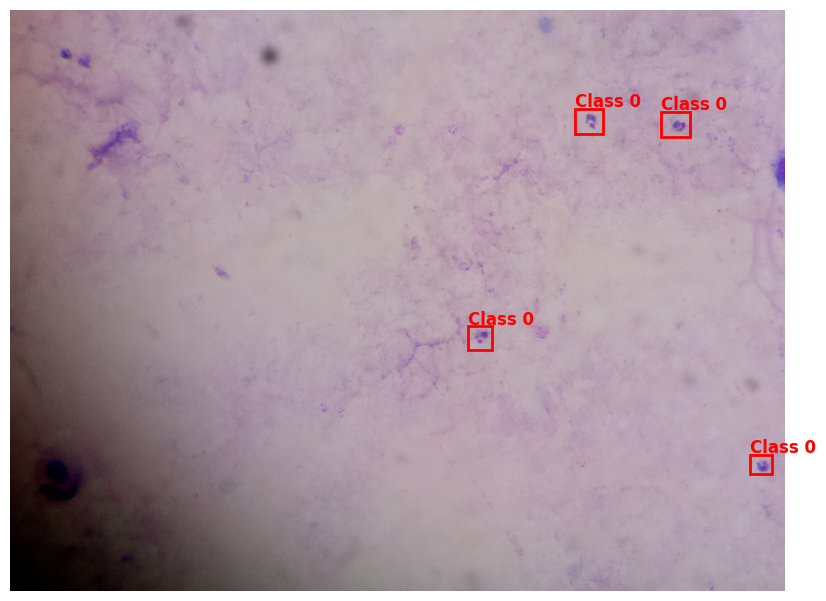

Plotting id_0s4fhpislz.jpg with 2 bounding boxes.


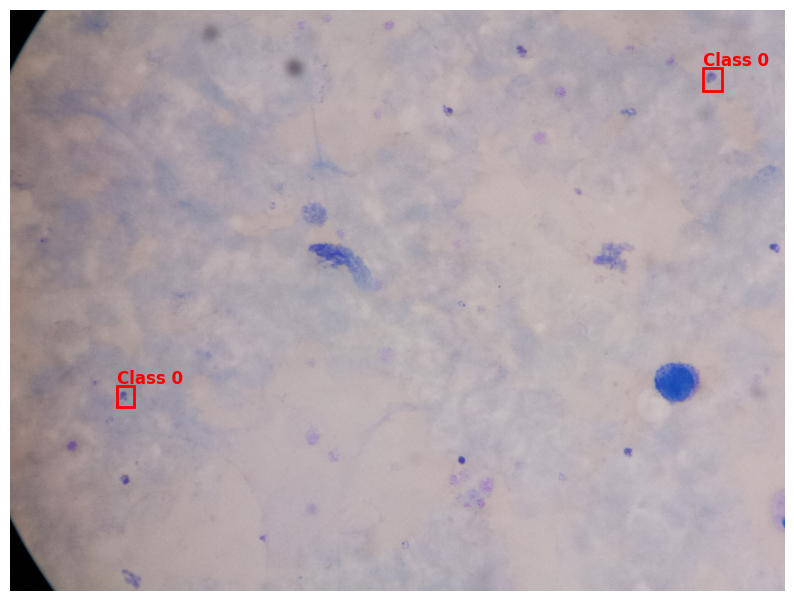

Plotting id_1i2c98t2s2.jpg with 5 bounding boxes.


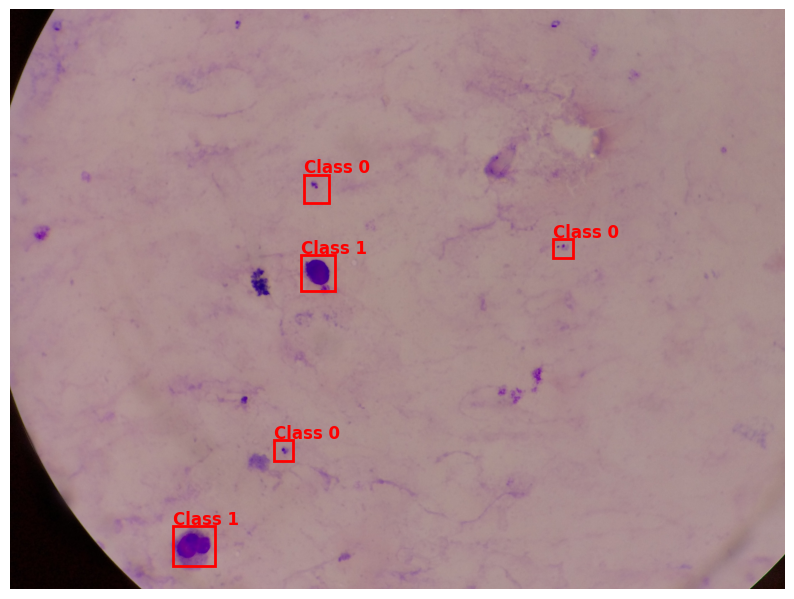

In [ ]:
# Plot some images and their bboxes to ensure the conversion was done correctly
def load_annotations(label_path):
    with open(label_path, 'r') as f:
        lines = f.readlines()
    boxes = []
    for line in lines:
        class_id, x_center, y_center, width, height = map(float, line.strip().split())
        boxes.append((class_id, x_center, y_center, width, height))
    return boxes

# Function to plot an image with its bounding boxes
def plot_image_with_boxes(image_path, boxes):
    # Load the image
    image = cv2.imread(str(image_path))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Get image dimensions
    h, w, _ = image.shape

    # Plot the image
    plt.figure(figsize=(10, 10))
    plt.imshow(image)

    # Plot each bounding box
    for box in boxes:
        class_id, x_center, y_center, width, height = box
        # Convert YOLO format to corner coordinates
        xmin = int((x_center - width / 2) * w)
        ymin = int((y_center - height / 2) * h)
        xmax = int((x_center + width / 2) * w)
        ymax = int((y_center + height / 2) * h)

        # Draw the bounding box
        plt.gca().add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                          edgecolor='red', facecolor='none', linewidth=2))
        plt.text(xmin, ymin - 10, f'Class {int(class_id)}', color='red', fontsize=12, weight='bold')

    plt.axis('off')
    plt.show()

# Directories for images and labels
IMAGE_DIR = TRAIN_IMAGES_DIR
LABEL_DIR = TRAIN_LABELS_DIR

# Plot a few images with their annotations
for image_name in os.listdir(IMAGE_DIR)[:3]:
    image_path = IMAGE_DIR / image_name
    label_path = LABEL_DIR / (image_name.replace('.jpg', '.txt').replace('.png', '.txt'))

    if label_path.exists():
        boxes = load_annotations(label_path)
        print(f"Plotting {image_name} with {len(boxes)} bounding boxes.")
        plot_image_with_boxes(image_path, boxes)
    else:
        print(f"No annotations found for {image_name}.")


In [ ]:
!export PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True

In [ ]:
#import gc

#model.to('cpu')
#del model
#gc.collect()
#torch.cuda.empty_cache()

In [ ]:
# Load a yolo pretrained model
model = YOLO('yolov8m.pt')

# Fine tune model to our data
model.train(
    data='data.yaml',          # Path to the dataset configuration
    epochs=15,                 # Number of epochs
    imgsz=2048,                # Image size (height, width)
    batch=4,                   # Batch size
    device=0,                  # Device to use (0 for the first GPU)
    patience=5)

100%|██████████| 49.7M/49.7M [00:00<00:00, 335MB/s]


Ultralytics 8.3.39 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=data.yaml, epochs=15, time=None, patience=5, batch=4, imgsz=2048, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=None

100%|██████████| 755k/755k [00:00<00:00, 20.8MB/s]


Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.conv.Conv             [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.block.C2f             [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.block.C2f             [192, 192, 4, True]           
  5                  -1  1    664320  ultralytics.nn.modules.conv.Conv             [192, 384, 3, 2]              
  6                  -1  4   3248640  ultralytics.nn.modules.block.C2f             [384, 384, 4, True]           
  7                  -1  1   1991808  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 104MB/s]


AMP: checks passed ✅


train: Scanning /content/datasets/dataset/labels/train... 1544 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1544/1544 [00:05<00:00, 296.48it/s]

train: New cache created: /content/datasets/dataset/labels/train.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /content/datasets/dataset/labels/val... 515 images, 0 backgrounds, 0 corrupt: 100%|██████████| 515/515 [00:01<00:00, 291.40it/s]


val: New cache created: /content/datasets/dataset/labels/val.cache
Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 2048 train, 2048 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 15 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/15      15.6G       2.79      6.288      2.384         35       2048:   2%|▏         | 7/386 [00:13<12:20,  1.95s/it]

       1/15      15.6G      2.791      6.052       2.31         79       2048:   2%|▏         | 9/386 [00:29<28:26,  4.53s/it]

       1/15      15.6G      2.716      5.433      2.199         36       2048:   5%|▌         | 21/386 [00:50<08:53,  1.46s/it]

       1/15      15.6G      2.351      4.383      1.881         62       2048:  10%|█         | 40/386 [01:21<07:18,  1.27s/it]

       1/15      15.6G      2.341      4.333      1.867        114       2048:  11%|█         | 41/386 [01:28<17:32,  3.05s/it]

       1/15      15.6G      2.317      4.266      1.843         44       2048:  11%|█         | 43/386 [01:35<17:28,  3.06s/it]

       1/15      15.6G      2.299      4.183      1.823         48       2048:  12%|█▏        | 45/386 [01:40<15:41,  2.76s/it]

       1/15      15.5G      2.251      4.012      1.776        108       2048:  13%|█▎        | 51/386 [01:54<09:48,  1.76s/it]

       1/15      15.5G      2.234      3.955      1.762         81       2048:  14%|█▎        | 53/386 [01:59<11:26,  2.06s/it]

       1/15      15.5G      2.175      3.751      1.711         55       2048:  16%|█▌        | 62/386 [02:16<07:24,  1.37s/it]

       1/15      15.5G      2.155      3.641      1.694         39       2048:  17%|█▋        | 67/386 [02:26<08:52,  1.67s/it]

       1/15      15.5G      2.117      3.432      1.664         53       2048:  20%|██        | 79/386 [02:46<07:01,  1.37s/it]

       1/15      15.5G      2.112      3.406      1.657         40       2048:  21%|██        | 81/386 [02:53<11:38,  2.29s/it]

       1/15      15.5G      2.097      3.328      1.647         97       2048:  22%|██▏       | 86/386 [03:02<08:19,  1.66s/it]

       1/15      15.5G      2.094      3.308      1.645        150       2048:  23%|██▎       | 87/386 [03:09<17:23,  3.49s/it]

       1/15      15.5G      2.082      3.251      1.639         55       2048:  24%|██▎       | 91/386 [03:17<09:58,  2.03s/it]

       1/15      15.5G      2.077      3.227      1.636         43       2048:  24%|██▍       | 93/386 [03:24<13:02,  2.67s/it]

       1/15      15.5G      2.061      3.121      1.621         65       2048:  26%|██▌       | 101/386 [03:40<07:22,  1.55s/it]

       1/15      15.5G      2.057      3.098      1.618         61       2048:  27%|██▋       | 103/386 [03:48<11:33,  2.45s/it]

       1/15      15.5G      2.049      3.041      1.606        101       2048:  28%|██▊       | 109/386 [04:03<08:29,  1.84s/it]

       1/15      15.5G      2.044      3.026      1.602         45       2048:  29%|██▉       | 111/386 [04:12<13:10,  2.87s/it]

       1/15      15.5G       2.03      2.958      1.593         48       2048:  31%|███       | 119/386 [04:25<06:42,  1.51s/it]

       1/15      15.5G      2.024      2.927      1.588         84       2048:  32%|███▏      | 123/386 [04:36<08:23,  1.91s/it]

       1/15      15.5G      2.022      2.898      1.585         40       2048:  33%|███▎      | 127/386 [04:46<08:43,  2.02s/it]

       1/15      15.5G      2.019       2.86      1.581         88       2048:  34%|███▍      | 131/386 [04:56<08:06,  1.91s/it]

       1/15      15.5G      2.017      2.837      1.581         78       2048:  35%|███▍      | 134/386 [05:03<08:37,  2.05s/it]

       1/15      15.5G      2.013      2.809      1.579         74       2048:  35%|███▌      | 137/386 [05:12<09:42,  2.34s/it]

       1/15      15.5G      2.013      2.801      1.578         98       2048:  36%|███▌      | 138/386 [05:17<12:04,  2.92s/it]

       1/15      15.5G       2.01       2.78      1.578         43       2048:  37%|███▋      | 141/386 [05:28<11:53,  2.91s/it]

       1/15      15.5G      1.977      2.604      1.567         27       2048:  45%|████▍     | 173/386 [06:14<04:36,  1.30s/it]

       1/15      15.5G      1.975      2.594      1.568         52       2048:  45%|████▌     | 175/386 [06:23<09:12,  2.62s/it]

       1/15      15.5G      1.972      2.565      1.566        102       2048:  47%|████▋     | 181/386 [06:35<05:36,  1.64s/it]

       1/15      15.5G      1.969      2.542      1.566         51       2048:  48%|████▊     | 185/386 [06:43<05:45,  1.72s/it]

       1/15      15.5G      1.969      2.534      1.565         99       2048:  48%|████▊     | 187/386 [06:50<08:02,  2.42s/it]

       1/15      15.5G      1.962      2.445      1.567         88       2048:  54%|█████▍    | 209/386 [07:22<04:03,  1.37s/it]

       1/15      15.5G       1.96      2.438      1.565         54       2048:  55%|█████▍    | 211/386 [07:31<07:36,  2.61s/it]

       1/15      15.5G      1.959      2.428      1.564         58       2048:  56%|█████▌    | 216/386 [07:43<05:28,  1.93s/it]

       1/15      15.5G      1.958      2.416      1.564         42       2048:  57%|█████▋    | 221/386 [07:53<04:41,  1.71s/it]

       1/15      15.5G      1.955      2.396      1.562         60       2048:  59%|█████▉    | 228/386 [08:09<04:18,  1.63s/it]

       1/15      15.5G      1.953      2.379      1.561         29       2048:  61%|██████    | 235/386 [08:23<03:51,  1.53s/it]

       1/15      15.5G       1.95      2.369      1.562         35       2048:  62%|██████▏   | 239/386 [08:31<04:06,  1.68s/it]

       1/15      15.5G      1.949       2.36      1.562         73       2048:  63%|██████▎   | 243/386 [08:41<04:31,  1.90s/it]

       1/15      15.5G      1.947      2.351      1.563         61       2048:  64%|██████▍   | 247/386 [08:50<04:09,  1.79s/it]

       1/15      15.5G      1.947      2.342      1.562         63       2048:  65%|██████▍   | 250/386 [08:57<04:15,  1.88s/it]

       1/15      15.5G      1.948      2.339      1.562        152       2048:  65%|██████▌   | 251/386 [09:04<07:51,  3.49s/it]

       1/15      15.5G      1.947      2.333      1.561        106       2048:  66%|██████▌   | 253/386 [09:10<06:54,  3.12s/it]

       1/15      15.5G      1.947      2.329       1.56         98       2048:  66%|██████▌   | 254/386 [09:14<07:24,  3.37s/it]

       1/15      15.5G      1.946      2.319      1.563         32       2048:  67%|██████▋   | 260/386 [09:27<03:46,  1.80s/it]

       1/15      15.5G      1.944      2.292      1.562         77       2048:  70%|███████   | 272/386 [09:47<02:34,  1.35s/it]

       1/15      15.5G      1.946      2.288      1.562         95       2048:  71%|███████   | 274/386 [10:04<07:45,  4.16s/it]

       1/15      15.5G      1.945      2.282      1.561         69       2048:  72%|███████▏  | 278/386 [10:12<04:14,  2.35s/it]

       1/15      15.5G      1.946      2.279      1.561        164       2048:  72%|███████▏  | 279/386 [10:19<06:27,  3.62s/it]

       1/15      15.5G      1.946      2.273       1.56         51       2048:  73%|███████▎  | 282/386 [10:27<04:34,  2.64s/it]

       1/15      15.5G      1.945       2.27      1.559         55       2048:  74%|███████▎  | 284/386 [10:34<05:00,  2.95s/it]

       1/15      15.5G      1.943      2.262      1.558         52       2048:  75%|███████▍  | 288/386 [10:46<03:53,  2.38s/it]

       1/15      15.5G      1.942      2.253      1.557         68       2048:  76%|███████▌  | 292/386 [10:56<03:12,  2.04s/it]

       1/15      15.5G       1.94       2.24      1.555         73       2048:  77%|███████▋  | 297/386 [11:08<02:42,  1.83s/it]

       1/15      15.5G      1.939      2.231      1.554         65       2048:  78%|███████▊  | 301/386 [11:15<02:23,  1.69s/it]

       1/15      15.5G      1.936      2.216      1.552         51       2048:  80%|███████▉  | 308/386 [11:29<01:57,  1.51s/it]

       1/15      15.5G      1.935      2.207      1.552         60       2048:  81%|████████▏ | 314/386 [11:42<01:54,  1.59s/it]

       1/15      15.5G      1.935      2.199      1.552         66       2048:  82%|████████▏ | 318/386 [11:52<02:05,  1.84s/it]

       1/15      15.5G      1.934      2.187       1.55         92       2048:  84%|████████▍ | 325/386 [12:07<01:34,  1.54s/it]

       1/15      15.5G      1.934      2.186       1.55        110       2048:  84%|████████▍ | 326/386 [12:11<02:27,  2.46s/it]

       1/15      15.5G      1.933      2.158       1.55         65       2048:  89%|████████▉ | 343/386 [12:39<00:58,  1.36s/it]

       1/15      15.5G      1.932      2.152       1.55         85       2048:  90%|████████▉ | 347/386 [12:48<01:04,  1.66s/it]

       1/15      15.5G      1.931      2.145      1.549         92       2048:  91%|█████████ | 351/386 [12:56<00:59,  1.69s/it]

       1/15      15.5G      1.932      2.144      1.549        105       2048:  91%|█████████ | 352/386 [13:02<01:47,  3.15s/it]

       1/15      15.5G      1.932       2.13      1.552         33       2048:  94%|█████████▍| 362/386 [13:19<00:35,  1.48s/it]

       1/15      15.5G      1.932      2.127      1.552         51       2048:  95%|█████████▍| 365/386 [13:28<00:44,  2.12s/it]

       1/15      15.5G      1.931      2.122      1.551         92       2048:  95%|█████████▌| 368/386 [13:35<00:36,  2.03s/it]

       1/15      15.5G      1.931       2.12      1.551         87       2048:  96%|█████████▌| 369/386 [13:42<00:59,  3.49s/it]

       1/15      15.5G      1.931      2.116      1.551         62       2048:  97%|█████████▋| 373/386 [13:50<00:27,  2.09s/it]

       1/15      15.5G      1.931      2.115      1.551         82       2048:  97%|█████████▋| 374/386 [13:53<00:31,  2.61s/it]

       1/15      15.5G      1.931       2.11      1.551        108       2048:  98%|█████████▊| 379/386 [14:08<00:14,  2.09s/it]

       1/15      15.5G       1.93      2.102      1.551         57       2048:  99%|█████████▉| 384/386 [14:17<00:03,  1.67s/it]

       1/15      15.5G       1.93      2.101      1.551        183       2048: 100%|█████████▉| 385/386 [14:25<00:03,  3.59s/it]

       1/15      15.5G       1.93      2.099       1.55        114       2048: 100%|██████████| 386/386 [14:29<00:00,  2.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 65/65 [01:04<00:00,  1.00it/s]


                   all        515       5488       0.59      0.663      0.671      0.331

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/15        15G      1.811      1.521       1.63         78       2048:   3%|▎         | 11/386 [00:14<08:23,  1.34s/it]

       2/15      15.3G      1.829      1.531      1.606         64       2048:   5%|▌         | 21/386 [00:35<08:40,  1.42s/it]

       2/15      15.6G      1.875       1.59      1.595         77       2048:  13%|█▎        | 51/386 [01:22<07:31,  1.35s/it]

       2/15      15.6G      1.872      1.601      1.584         38       2048:  15%|█▍        | 57/386 [01:34<08:27,  1.54s/it]

       2/15      15.6G      1.872      1.575      1.586        108       2048:  25%|██▌       | 97/386 [02:36<06:20,  1.32s/it]

       2/15      15.6G      1.875      1.579      1.583         44       2048:  28%|██▊       | 107/386 [02:58<07:04,  1.52s/it]

       2/15      15.6G      1.883      1.553      1.578         90       2048:  41%|████▏     | 160/386 [04:16<04:53,  1.30s/it]

       2/15      15.6G      1.885      1.544      1.578         38       2048:  48%|████▊     | 186/386 [05:00<04:31,  1.36s/it]

       2/15      15.6G      1.886      1.553      1.574         68       2048:  53%|█████▎    | 203/386 [05:30<04:12,  1.38s/it]

       2/15      15.6G      1.883      1.553       1.57        137       2048:  72%|███████▏  | 276/386 [07:12<02:26,  1.34s/it]

       2/15      15.6G       1.88      1.547      1.569        104       2048:  76%|███████▌  | 293/386 [07:40<02:00,  1.30s/it]

       2/15      15.6G      1.884      1.539      1.563         68       2048:  89%|████████▉ | 343/386 [08:54<00:56,  1.31s/it]

       2/15      15.6G      1.875      1.546      1.561         66       2048: 100%|██████████| 386/386 [10:01<00:00,  1.56s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 65/65 [01:03<00:00,  1.02it/s]


                   all        515       5488      0.719      0.744      0.749      0.367

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/15      15.6G      1.819      1.542      1.549         35       2048:   5%|▍         | 19/386 [00:30<08:25,  1.38s/it]

       3/15      15.6G      1.826      1.501      1.562         27       2048:  12%|█▏        | 47/386 [01:16<07:28,  1.32s/it]

       3/15      15.6G      1.846      1.527      1.562        135       2048:  15%|█▍        | 56/386 [01:37<08:20,  1.52s/it]

       3/15      15.6G      1.851      1.525       1.56        115       2048:  15%|█▌        | 59/386 [01:54<18:17,  3.36s/it]

       3/15      15.6G      1.858      1.514      1.547         55       2048:  20%|██        | 78/386 [02:27<07:17,  1.42s/it]

       3/15      15.6G       1.85      1.541      1.552         51       2048:  33%|███▎      | 129/386 [03:43<06:09,  1.44s/it]

       3/15      15.6G       1.85      1.526      1.541         58       2048:  82%|████████▏ | 318/386 [08:17<01:42,  1.51s/it]

       3/15      15.6G       1.85      1.525      1.541         73       2048:  83%|████████▎ | 322/386 [08:31<02:23,  2.25s/it]

       3/15      15.6G      1.851      1.525       1.54         90       2048:  84%|████████▍ | 324/386 [08:39<03:02,  2.94s/it]

       3/15      15.6G      1.852      1.536      1.542         95       2048:  96%|█████████▌| 371/386 [09:51<00:20,  1.34s/it]

       3/15      15.6G      1.854      1.539      1.543         32       2048: 100%|██████████| 386/386 [10:16<00:00,  1.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 65/65 [01:05<00:00,  1.00s/it]

                   all        515       5488       0.64      0.714       0.72      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/15      15.6G      1.911      1.597      1.568         91       2048:   3%|▎         | 13/386 [00:23<09:46,  1.57s/it]

       4/15      15.6G      1.891      1.576      1.537        109       2048:   4%|▍         | 17/386 [00:41<16:08,  2.63s/it]

       4/15      15.6G      1.829      1.481      1.503         37       2048:   9%|▉         | 36/386 [01:15<07:45,  1.33s/it]

       4/15      15.6G      1.821      1.515      1.505        104       2048:  18%|█▊        | 69/386 [02:08<06:55,  1.31s/it]

       4/15      15.6G      1.817      1.507      1.511         47       2048:  33%|███▎      | 129/386 [03:50<05:48,  1.36s/it]

       4/15      15.6G      1.826      1.492      1.509         56       2048:  44%|████▍     | 169/386 [04:52<04:47,  1.32s/it]

       4/15      15.6G      1.826      1.479       1.51         59       2048:  53%|█████▎    | 204/386 [05:47<03:59,  1.32s/it]

       4/15      15.6G       1.83      1.467      1.514        104       2048:  66%|██████▌   | 254/386 [07:00<02:56,  1.34s/it]

       4/15      15.6G      1.835      1.472       1.52         97       2048:  92%|█████████▏| 355/386 [09:22<00:40,  1.30s/it]

       4/15      15.6G      1.836      1.466      1.524         66       2048: 100%|██████████| 386/386 [10:10<00:00,  1.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 65/65 [01:07<00:00,  1.03s/it]

                   all        515       5488      0.732      0.747       0.77      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/15      15.4G       1.83      1.394       1.64         41       2048:   2%|▏         | 9/386 [00:14<11:42,  1.86s/it]

       5/15      15.4G      1.854      1.375       1.59         57       2048:  10%|▉         | 37/386 [01:01<11:53,  2.04s/it]

       5/15      15.3G      1.853      1.376      1.575         46       2048:  11%|█         | 41/386 [01:21<17:42,  3.08s/it]

       5/15      15.3G      1.848      1.373      1.571         69       2048:  11%|█▏        | 44/386 [01:31<15:47,  2.77s/it]

       5/15      15.3G      1.845      1.375      1.573         55       2048:  13%|█▎        | 49/386 [01:43<10:55,  1.95s/it]

       5/15      15.3G      1.842      1.375      1.554         83       2048:  15%|█▌        | 59/386 [02:02<07:28,  1.37s/it]

       5/15      15.3G      1.839       1.37       1.55        131       2048:  16%|█▋        | 63/386 [02:14<11:14,  2.09s/it]

       5/15      15.6G      1.824      1.411      1.558         27       2048:  34%|███▍      | 132/386 [03:55<05:43,  1.35s/it]

       5/15      15.6G      1.823      1.413      1.554         55       2048:  36%|███▋      | 140/386 [04:10<05:53,  1.44s/it]

       5/15      15.6G      1.831       1.41       1.55        104       2048:  45%|████▍     | 173/386 [05:00<04:38,  1.31s/it]

       5/15      15.6G      1.837      1.411      1.553         97       2048:  49%|████▉     | 189/386 [05:25<04:17,  1.31s/it]

       5/15      15.6G      1.841      1.409      1.553         59       2048:  52%|█████▏    | 199/386 [05:45<04:20,  1.39s/it]

       5/15      15.6G      1.841      1.409      1.552        145       2048:  52%|█████▏    | 200/386 [05:55<11:53,  3.84s/it]

       5/15      15.6G      1.839      1.406      1.547         50       2048:  57%|█████▋    | 220/386 [06:27<03:37,  1.31s/it]

       5/15      15.6G       1.84      1.401      1.543         47       2048:  59%|█████▉    | 229/386 [06:47<03:45,  1.44s/it]

       5/15      15.6G      1.842      1.396      1.539         45       2048:  70%|███████   | 272/386 [07:52<02:30,  1.32s/it]

       5/15      15.6G      1.841       1.39       1.54         59       2048:  83%|████████▎ | 321/386 [09:03<01:24,  1.30s/it]

       5/15      15.6G      1.839      1.381      1.539         49       2048:  90%|█████████ | 348/386 [09:44<00:49,  1.30s/it]

       5/15      15.6G       1.84       1.38      1.541         73       2048:  97%|█████████▋| 373/386 [10:24<00:17,  1.37s/it]

       5/15      15.6G      1.841      1.381      1.541        118       2048:  98%|█████████▊| 377/386 [10:34<00:16,  1.80s/it]

       5/15      15.6G      1.841      1.382      1.541         34       2048:  99%|█████████▉| 383/386 [10:49<00:05,  1.75s/it]

       5/15      15.6G      1.842      1.383       1.54         69       2048: 100%|█████████▉| 385/386 [10:58<00:02,  2.93s/it]

       5/15      15.6G      1.842      1.383       1.54        118       2048: 100%|██████████| 386/386 [11:04<00:00,  1.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 65/65 [00:59<00:00,  1.09it/s]

                   all        515       5488      0.649      0.628      0.686      0.349


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/15      15.4G       1.94      1.691      1.664         77       2048:   1%|          | 3/386 [00:05<11:42,  1.84s/it]

       6/15      15.4G      1.824      1.373      1.592         85       2048:  39%|███▉      | 152/386 [04:53<05:23,  1.38s/it]

       6/15      15.4G      1.818      1.367      1.593         25       2048:  69%|██████▊   | 265/386 [07:48<02:40,  1.33s/it]

       6/15      15.4G      1.818      1.368      1.591         37       2048:  69%|██████▉   | 267/386 [08:00<06:36,  3.33s/it]

       6/15      15.4G      1.821       1.37      1.594         31       2048:  94%|█████████▍| 364/386 [10:13<00:28,  1.31s/it]

       6/15      15.4G      1.821      1.367      1.592         48       2048: 100%|██████████| 386/386 [10:49<00:00,  1.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 65/65 [01:06<00:00,  1.02s/it]


                   all        515       5488      0.711      0.702      0.736      0.366

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/15      12.4G      1.659      1.155      1.567         32       2048:   0%|          | 1/386 [00:01<09:19,  1.45s/it]

       7/15      15.4G      1.832      1.301       1.59         27       2048:  18%|█▊        | 69/386 [01:36<06:45,  1.28s/it]

       7/15      15.4G      1.835      1.317      1.606         31       2048:  47%|████▋     | 183/386 [04:09<04:31,  1.34s/it]

       7/15      15.4G      1.839      1.326      1.609         29       2048:  57%|█████▋    | 221/386 [05:04<03:31,  1.28s/it]

       7/15      15.4G      1.841      1.326      1.613         40       2048:  61%|██████▏   | 237/386 [05:29<03:20,  1.35s/it]

       7/15      15.4G      1.839      1.326      1.609         20       2048:  67%|██████▋   | 259/386 [06:03<02:42,  1.28s/it]

       7/15      15.4G      1.837      1.326      1.606         60       2048:  71%|███████   | 274/386 [06:27<02:28,  1.32s/it]

       7/15      15.4G      1.838      1.327      1.605         32       2048:  73%|███████▎  | 280/386 [06:43<02:55,  1.65s/it]

       7/15      15.4G      1.836      1.331      1.604         48       2048:  76%|███████▌  | 293/386 [07:07<02:03,  1.33s/it]

       7/15      15.4G      1.825      1.329        1.6         49       2048:  92%|█████████▏| 355/386 [08:46<01:06,  2.14s/it]

       7/15      15.4G      1.824      1.327      1.599         23       2048: 100%|██████████| 386/386 [09:41<00:00,  1.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 65/65 [03:50<00:00,  3.54s/it]

                   all        515       5488      0.714      0.753      0.759      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/15      15.6G      1.823      1.328      1.632         42       2048:   6%|▋         | 25/386 [00:33<07:58,  1.33s/it]

       8/15      15.6G      1.813        1.3       1.61         24       2048:  10%|▉         | 37/386 [00:54<07:50,  1.35s/it]

       8/15      15.6G      1.804      1.282      1.591         52       2048:  65%|██████▌   | 251/386 [05:44<02:58,  1.32s/it]

       8/15      15.6G      1.804      1.289      1.598         28       2048:  78%|███████▊  | 301/386 [06:58<01:50,  1.30s/it]

       8/15      15.6G      1.808      1.289      1.599         17       2048: 100%|██████████| 386/386 [08:57<00:00,  1.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 65/65 [02:44<00:00,  2.53s/it]

                   all        515       5488       0.76      0.787      0.808      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/15      15.4G        1.8      1.206      1.675         34       2048:   3%|▎         | 12/386 [00:16<08:08,  1.31s/it]

       9/15      15.4G      1.823      1.227      1.673        108       2048:   3%|▎         | 13/386 [00:27<27:08,  4.36s/it]

       9/15      15.4G      1.818      1.216      1.629         27       2048:   6%|▌         | 23/386 [00:46<08:43,  1.44s/it]

       9/15      15.4G      1.813      1.239      1.599         42       2048:  52%|█████▏    | 199/386 [04:41<04:02,  1.30s/it]

       9/15      15.4G      1.809      1.236      1.601         88       2048:  59%|█████▉    | 229/386 [05:26<03:28,  1.33s/it]

       9/15      15.4G      1.804      1.239      1.598         41       2048:  65%|██████▌   | 251/386 [06:00<02:52,  1.28s/it]

       9/15      15.4G      1.804       1.24      1.596         56       2048:  77%|███████▋  | 299/386 [07:09<01:54,  1.32s/it]

       9/15      15.4G      1.808      1.244      1.595         35       2048:  86%|████████▌ | 331/386 [07:57<01:13,  1.33s/it]

       9/15      15.4G      1.804      1.245      1.597         17       2048: 100%|██████████| 386/386 [09:13<00:00,  1.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 65/65 [01:46<00:00,  1.63s/it]

                   all        515       5488      0.744      0.804      0.817      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/15      15.4G       1.81      1.252      1.554         46       2048:  15%|█▍        | 57/386 [01:14<07:09,  1.31s/it]

      10/15      15.4G      1.807      1.252       1.56         30       2048:  23%|██▎       | 87/386 [01:58<06:36,  1.33s/it]

      10/15      15.4G      1.805      1.235      1.573         55       2048:  34%|███▍      | 133/386 [03:02<05:27,  1.29s/it]

      10/15      15.4G      1.802      1.241      1.582         49       2048:  59%|█████▉    | 229/386 [05:10<03:20,  1.28s/it]

      10/15      15.4G      1.794      1.242      1.589         43       2048:  72%|███████▏  | 277/386 [06:16<02:22,  1.31s/it]

      10/15      15.4G      1.789      1.249      1.585         16       2048:  82%|████████▏ | 315/386 [07:10<01:30,  1.28s/it]

      10/15      15.4G      1.793      1.252      1.583         22       2048:  94%|█████████▍| 363/386 [08:17<00:30,  1.31s/it]

      10/15      15.4G      1.793       1.25      1.582         43       2048:  95%|█████████▍| 366/386 [08:26<00:40,  2.02s/it]

      10/15      15.4G      1.792      1.245       1.58         92       2048: 100%|██████████| 386/386 [08:56<00:00,  1.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 65/65 [01:06<00:00,  1.02s/it]

                   all        515       5488      0.765      0.781      0.804      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/15      15.6G      1.782      1.194       1.58         51       2048: 100%|██████████| 386/386 [08:23<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 65/65 [00:59<00:00,  1.08it/s]

                   all        515       5488      0.768      0.796      0.818      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/15      15.4G       1.75      1.199      1.568         59       2048:   4%|▎         | 14/386 [00:18<07:59,  1.29s/it]

      12/15      15.4G      1.764      1.208      1.552         33       2048:  16%|█▌        | 61/386 [01:24<07:01,  1.30s/it]

      12/15      15.4G      1.772      1.183       1.56         50       2048:  26%|██▌       | 99/386 [02:18<06:10,  1.29s/it]

      12/15      15.4G      1.786       1.18      1.569         50       2048:  68%|██████▊   | 263/386 [06:00<02:48,  1.37s/it]

      12/15      15.4G      1.786      1.181      1.568         80       2048:  68%|██████▊   | 264/386 [06:07<06:14,  3.07s/it]

      12/15      15.4G      1.789      1.181      1.568         86       2048:  71%|███████   | 275/386 [06:29<02:36,  1.41s/it]

      12/15      15.4G      1.783      1.175      1.565         67       2048:  80%|████████  | 309/386 [07:16<01:38,  1.28s/it]

      12/15      15.4G      1.783      1.173      1.566         26       2048:  87%|████████▋ | 334/386 [07:53<01:07,  1.31s/it]

      12/15      15.4G      1.784      1.179      1.572         71       2048: 100%|██████████| 386/386 [09:04<00:00,  1.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 65/65 [01:00<00:00,  1.07it/s]

                   all        515       5488      0.774        0.8      0.825      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/15      15.3G      1.756      1.141      1.578         14       2048:  30%|███       | 117/386 [02:32<05:46,  1.29s/it]

      13/15      15.3G      1.763      1.147      1.574         34       2048:  41%|████      | 159/386 [03:30<05:04,  1.34s/it]

      13/15      15.3G      1.763      1.145      1.573         29       2048:  44%|████▍     | 171/386 [03:49<04:49,  1.35s/it]

      13/15      15.3G      1.771      1.144      1.568         42       2048:  56%|█████▌    | 215/386 [04:51<03:45,  1.32s/it]

      13/15      15.3G       1.77      1.139      1.569         47       2048:  61%|██████    | 235/386 [05:20<03:12,  1.28s/it]

      13/15      15.3G      1.766      1.136      1.567         67       2048:  73%|███████▎  | 283/386 [06:29<02:14,  1.31s/it]

      13/15      15.3G      1.767      1.136      1.568         35       2048:  80%|███████▉  | 307/386 [07:04<01:41,  1.29s/it]

      13/15      15.3G      1.764      1.133      1.565         33       2048:  89%|████████▉ | 344/386 [07:58<00:54,  1.29s/it]

      13/15      15.3G      1.764       1.13      1.566         70       2048: 100%|██████████| 386/386 [08:57<00:00,  1.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 65/65 [01:01<00:00,  1.06it/s]

                   all        515       5488      0.786      0.791      0.822      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/15      15.4G      1.771      1.123       1.56         40       2048:   5%|▍         | 19/386 [00:24<07:43,  1.26s/it]

      14/15      15.4G      1.772      1.145      1.548         18       2048:  17%|█▋        | 66/386 [01:30<06:45,  1.27s/it]

      14/15      15.4G      1.776      1.149      1.549         44       2048:  18%|█▊        | 69/386 [01:41<12:31,  2.37s/it]

      14/15      15.4G      1.773      1.159       1.55         59       2048:  27%|██▋       | 103/386 [02:27<05:58,  1.27s/it]

      14/15      15.4G      1.771       1.16      1.555         54       2048:  28%|██▊       | 109/386 [02:40<06:59,  1.52s/it]

      14/15      15.4G      1.765      1.144      1.554         32       2048:  68%|██████▊   | 263/386 [06:04<02:37,  1.28s/it]

      14/15      15.4G      1.762      1.143      1.554         24       2048:  74%|███████▍  | 285/386 [06:35<02:13,  1.32s/it]

      14/15      15.4G      1.756      1.133      1.545         46       2048:  91%|█████████ | 351/386 [08:06<00:44,  1.27s/it]

      14/15      15.4G      1.757       1.13      1.543         50       2048:  94%|█████████▎| 361/386 [08:23<00:33,  1.33s/it]

      14/15      15.4G      1.758      1.129      1.543         49       2048:  99%|█████████▊| 381/386 [08:52<00:06,  1.31s/it]

      14/15      15.4G      1.758      1.129      1.542         39       2048: 100%|██████████| 386/386 [09:04<00:00,  1.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 65/65 [00:59<00:00,  1.08it/s]

                   all        515       5488      0.783      0.813      0.835      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/15      15.4G      1.744      1.101       1.53         35       2048:  19%|█▉        | 75/386 [01:38<06:39,  1.28s/it]

      15/15      15.4G      1.744        1.1      1.539         27       2048:  22%|██▏       | 85/386 [01:54<06:43,  1.34s/it]

      15/15      15.4G      1.746      1.099      1.538         43       2048:  23%|██▎       | 88/386 [02:01<08:32,  1.72s/it]

      15/15      15.4G       1.74      1.095      1.539         53       2048:  37%|███▋      | 142/386 [03:18<05:10,  1.27s/it]

      15/15      15.4G      1.747      1.092      1.544         25       2048:  45%|████▌     | 175/386 [04:07<04:40,  1.33s/it]

      15/15      15.4G       1.75      1.092      1.557         43       2048:  83%|████████▎ | 321/386 [07:23<01:23,  1.28s/it]

      15/15      15.4G       1.75      1.088      1.555         29       2048:  87%|████████▋ | 335/386 [07:43<01:05,  1.28s/it]

      15/15      15.4G       1.75       1.09       1.56         16       2048: 100%|██████████| 386/386 [08:55<00:00,  1.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 65/65 [01:02<00:00,  1.04it/s]

                   all        515       5488      0.791      0.815      0.838      0.435



15 epochs completed in 2.831 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 52.4MB
Optimizer stripped from runs/detect/train/weights/best.pt, 52.4MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.39 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 218 layers, 25,840,918 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 65/65 [01:05<00:00,  1.01s/it]


                   all        515       5488       0.79      0.816      0.838      0.435
           Trophozoite        507       3896      0.687      0.662      0.695       0.28
                   WBC        392       1592      0.892      0.969      0.982       0.59
Speed: 1.7ms preprocess, 67.3ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7a046f45a4a0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

In [ ]:
# Validate the model on the validation set
model = YOLO('/content/runs/detect/train/weights/best.pt')
results = model.val()

Ultralytics 8.3.39 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 218 layers, 25,840,918 parameters, 0 gradients, 78.7 GFLOPs


val: Scanning /content/datasets/dataset/labels/val.cache... 515 images, 0 backgrounds, 0 corrupt: 100%|██████████| 515/515 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [03:42<00:00,  6.74s/it]


                   all        515       5488      0.789      0.816      0.838      0.437
           Trophozoite        507       3896      0.686      0.662      0.695      0.281
                   WBC        392       1592      0.891      0.969      0.982      0.593
Speed: 1.9ms preprocess, 140.1ms inference, 0.0ms loss, 9.0ms postprocess per image
Results saved to runs/detect/val


In [ ]:
# Load the trained YOLO model
model = YOLO('/content/runs/detect/train/weights/best.pt')

# Path to the test images directory
test_dir_path = '/content/datasets/dataset/images/test'

# Get a list of all image files in the test directory
image_files = os.listdir(test_dir_path)

# Initialize an empty list to store the results for all images
all_data = []

# Iterate through each image in the directory
for image_file in tqdm(image_files):
    # Full path to the image
    img_path = os.path.join(test_dir_path, image_file)

    # Make predictions on the image
    results = model(img_path)

    # Extract bounding boxes, confidence scores, and class labels
    boxes = results[0].boxes.xyxy.tolist()  # Bounding boxes in xyxy format
    classes = results[0].boxes.cls.tolist()  # Class indices
    confidences = results[0].boxes.conf.tolist()  # Confidence scores
    names = results[0].names  # Class names dictionary

    if not boxes:
        # If no detections, add NEG as the class
        all_data.append({
            'Image_ID': image_file,
            'class': 'NEG',
            'confidence': 1.0,  # You can set this to a default value
            'ymin': 0,  # Default value (no detection)
            'xmin': 0,  # Default value (no detection)
            'ymax': 0,  # Default value (no detection)
            'xmax': 0   # Default value (no detection)
        })
    else:
        # Iterate through the results for this image
        for box, cls, conf in zip(boxes, classes, confidences):
            x1, y1, x2, y2 = box
            detected_class = names[int(cls)]  # Get the class name from the names dictionary

            # Add the result to the all_data list
            all_data.append({
                'Image_ID': image_file,
                'class': detected_class,
                'confidence': conf,
                'ymin': y1,
                'xmin': x1,
                'ymax': y2,
                'xmax': x2
            })

# Convert the list to a DataFrame for all images
sub = pd.DataFrame(all_data)

  0%|          | 0/1178 [00:00<?, ?it/s]


image 1/1 /content/datasets/dataset/images/test/id_oxi3v101sp.jpg: 1536x2048 1 Trophozoite, 9 WBCs, 157.2ms
Speed: 46.1ms preprocess, 157.2ms inference, 10.3ms postprocess per image at shape (1, 3, 1536, 2048)

image 1/1 /content/datasets/dataset/images/test/id_y6a94b8duk.jpg: 1536x2048 11 WBCs, 143.5ms
Speed: 34.7ms preprocess, 143.5ms inference, 2.3ms postprocess per image at shape (1, 3, 1536, 2048)

image 1/1 /content/datasets/dataset/images/test/id_ycwcyn9qch.jpg: 1536x2048 6 Trophozoites, 3 WBCs, 151.8ms
Speed: 38.6ms preprocess, 151.8ms inference, 10.6ms postprocess per image at shape (1, 3, 1536, 2048)

image 1/1 /content/datasets/dataset/images/test/id_takxmc0c1v.jpg: 1536x2048 2 Trophozoites, 145.8ms
Speed: 58.9ms preprocess, 145.8ms inference, 2.4ms postprocess per image at shape (1, 3, 1536, 2048)

image 1/1 /content/datasets/dataset/images/test/id_dls5msrnfl.jpg: 1536x2048 9 Trophozoites, 143.5ms
Speed: 41.3ms preprocess, 143.5ms inference, 6.5ms postprocess per image at 

In [ ]:
sub.head()

,Image_ID,class,confidence,ymin,xmin,ymax,xmax
0,id_oxi3v101sp.jpg,WBC,0.761269,1084.439209,2071.383789,1235.753906,2226.713623
1,id_oxi3v101sp.jpg,WBC,0.736907,743.372498,543.273193,925.547791,720.555481
2,id_oxi3v101sp.jpg,WBC,0.734270,1606.512085,2024.666138,1772.937012,2198.231201
3,id_oxi3v101sp.jpg,WBC,0.717750,2229.499023,708.627991,2414.696289,893.098206
4,id_oxi3v101sp.jpg,WBC,0.691469,2363.005127,2316.499023,2523.583252,2465.769043


In [ ]:
sub['class'].value_counts()

,count
class,
Trophozoite,6147
WBC,5462
NEG,6


In [ ]:
# Create submission file to be uploaded to Zindi for scoring
sub.to_csv('benchmark_submission.csv', index = False)